In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%pwd

'/ocean/projects/asc170022p/mtragoza/med_vqa'

In [2]:
import sys, os, argparse, time, tqdm
from collections import defaultdict
import numpy as np
import pandas as pd
import torch
import open_clip
import transformers as T
import datasets, peft, evaluate
bleu_score_metric = evaluate.load('bleu')
from difflib import SequenceMatcher

In [3]:
assert torch.cuda.is_available(), 'No GPU devices available'

print('Available GPU devices:')
for i in range(torch.cuda.device_count()):
    print(f'  GPU {i}: {torch.cuda.get_device_properties(i).name}')

Available GPU devices:
  GPU 0: NVIDIA RTX A6000
  GPU 1: NVIDIA RTX A6000
  GPU 2: NVIDIA RTX A6000
  GPU 3: NVIDIA RTX A6000


In [4]:
%%time
class ImageEncoder(torch.nn.Module):
    
    @classmethod
    def from_name(cls, name, **kwargs):
        if name == 'CLIP':
            url = 'laion/CLIP-ViT-L-14-DataComp.XL-s13B-b90K' # (256, 1024)
        elif name == 'PMC-CLIP':
            url = 'ryanyip7777/pmc_vit_l_14'

        model, train_preprocess, val_preprocess = \
            open_clip.create_model_and_transforms(f'hf-hub:{url}', device=torch.device('cuda'))
    
        return cls(model.visual, train_preprocess, val_preprocess, n_patches=256, embed_size=1024, **kwargs)

    def __init__(self, vit, train_preprocess, val_preprocess, n_patches, embed_size, embed_type):
        super().__init__()

        self.train_preprocess = train_preprocess
        self.val_preprocess = val_preprocess

        self.vit = vit
        self.vit.output_tokens = True
        self.vit.proj = None
    
        self.embed_type = embed_type
        self.embed_size = embed_size
        
        if embed_type == 'both':
            self.seq_length = n_patches + 1
        elif embed_type == 'patch':
            self.seq_length = n_patches
        elif embed_type == 'global':
            self.seq_length = 1
        
    def forward(self, images):
        global_embeddings, patch_embeddings = self.vit(images)
        global_embeddings = global_embeddings.unsqueeze(1)
        
        if self.embed_type == 'global':
            image_embeddings = global_embeddings
        elif self.embed_type == 'patch':
            image_embeddings = patch_embeddings  
        elif self.embed_type == 'both':
            image_embeddings = torch.cat([global_embeddings, patch_embeddings], dim=1)
        
        assert image_embeddings.shape[1:] == (self.seq_length, self.embed_size), image_embeddings.shape
        return image_embeddings

image_encoder = ImageEncoder.from_name('CLIP', embed_type='both')
image_length = image_encoder.seq_length
image_length

CPU times: user 11.3 s, sys: 1.95 s, total: 13.2 s
Wall time: 14 s


257

In [5]:
%%time
class TextDecoder(torch.nn.Module):
    
    @classmethod
    def from_name(cls, name):
        if name == 'LLaMA':
            url = 'meta-llama/Llama-2-7b-hf'
        elif name == 'PMC-LLaMA':
            url = 'chaoyi-wu/PMC_LLAMA_7B'
        elif name == ' LLaVA':
            url = 'liuhaotian/llava-v1.6-vicuna-7b'
        
        llm = T.LlamaForCausalLM.from_pretrained(url, device_map='auto', cache_dir='models')
        tokenizer = T.LlamaTokenizer.from_pretrained(url, cache_dir='models')
        
        return cls(llm, tokenizer, max_length=512, embed_size=4096)

    def __init__(self, llm, tokenizer, max_length, embed_size):
        super().__init__()

        self.llm = llm
        self.tokenizer = tokenizer

        self.max_length = max_length
        self.embed_size = embed_size
        
    def forward(self, input_embeddings, mask, labels):
        assert input_embeddings.shape[1] <= self.max_length, input_embeddings.shape
        assert input_embeddings.shape[2] == self.embed_size, input_embeddings.shape

        return self.llm.forward(
            inputs_embeds=input_embeddings,
            attention_mask=mask,
            labels=labels
        )

    def generate(self, input_embeddings, mask, **kwargs):
        assert input_embeddings.shape[1] <= self.max_length, input_embeddings.shape
        assert input_embeddings.shape[2] == self.embed_size, input_embeddings.shape

        return self.llm.generate(
            inputs_embeds=input_embeddings,
            attention_mask=mask,
            **kwargs
        )

text_decoder = TextDecoder.from_name('LLaMA')
text_encoder = text_decoder.llm.model.embed_tokens

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 1min 3s, sys: 47.4 s, total: 1min 50s
Wall time: 11.1 s


In [6]:
class MultimodalFusion(torch.nn.Module):
    
    def __init__(self, image_embed_size, text_embed_size, device):
        super().__init__()
        self.image_embed_size = image_embed_size
        self.text_embed_size = text_embed_size

        self.project_image = torch.nn.Linear(
            image_embed_size, text_embed_size, device=device
        )
        
    def forward(self, image_embeddings, text_embeddings, mask):
        batch_size, image_length = image_embeddings.shape[:2]

        image_embeddings = self.project_image(image_embeddings)
        combined_embeddings = torch.cat([image_embeddings, text_embeddings], dim=1)

        image_mask = torch.ones((batch_size, image_length), device=mask.device)
        combined_mask = torch.cat([image_mask, mask], dim=1)

        return combined_embeddings, combined_mask

In [7]:
class VQAModel(torch.nn.Module):
    
    def __init__(self, image_encoder, text_encoder, text_decoder):
        super().__init__()

        self.image_encoder = image_encoder
        self.text_encoder  = text_encoder
        self.text_decoder  = text_decoder

        self.fusion_module = MultimodalFusion(
            image_encoder.embed_size,
            text_decoder.embed_size,
            device=text_decoder.llm.device
        )
        
    def combine_multimodal_inputs(self, images, padded_tokens, mask):   
        image_embeddings = self.image_encoder(images)
        text_embeddings  = self.text_encoder(padded_tokens)

        combined_embeddings, combined_mask = self.fusion_module(
            image_embeddings, text_embeddings, mask
        )
        return combined_embeddings, combined_mask
    
    def forward(self, images, padded_tokens, mask):       
        input_embeddings, mask = self.combine_multimodal_inputs(
            images, padded_tokens, mask
        )
        dummy_tokens = torch.zeros(
            (images.shape[0], self.image_encoder.seq_length),
            dtype=padded_tokens.dtype,
            device=padded_tokens.device
        )
        labels = torch.cat([dummy_tokens, padded_tokens], dim=1)
        
        output = self.text_decoder.forward(input_embeddings, mask, labels)
        return output

    def generate(self, images, padded_tokens, mask, **kwargs):
        input_embeddings, mask = self.combine_multimodal_inputs(
            images, padded_tokens, mask
        )
        output = self.text_decoder.generate(input_embeddings, mask, **kwargs)
        return output


model = VQAModel(image_encoder, text_encoder, text_decoder)
model

VQAModel(
  (image_encoder): ImageEncoder(
    (vit): VisionTransformer(
      (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (patch_dropout): Identity()
      (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): ModuleList(
          (0-23): 24 x ResidualAttentionBlock(
            (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
            )
            (ls_1): Identity()
            (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
              (gelu): GELU(approximate='none')
              (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
            )
            (ls_2): Identity()
      

In [8]:
class VQADataset(torch.utils.data.Dataset):
    
    @classmethod
    def from_name(cls, name, train_preprocess, val_preprocess, **kwargs):

        if name == 'VQA-RAD':
            url = 'flaviagiammarino/vqa-rad'
            val_split = 'test'
        elif name == 'SLAKE':
            url = 'BoKelvin/SLAKE'
            val_split = 'validation'

        ds = datasets.load_dataset(url, cache_dir='data')
        
        train_set = cls(ds['train'], train_preprocess, **kwargs)
        val_set = cls(ds[val_split], val_preprocess, **kwargs)
        test_set = cls(ds['test'], val_preprocess, **kwargs)

        return train_set, val_set, test_set
            
    def __init__(self, ds, image_preprocess, tokenizer, image_length, max_length, device):
        super().__init__()
        self.ds = ds
        
        # image preprocessor
        self.image_preprocess = image_preprocess
        
        # text tokenizer
        self.tokenizer = tokenizer
        self.tokenizer.pad_token = tokenizer.eos_token

        assert max_length > image_length
        self.image_length = image_length
        self.max_length = max_length
        self.device = device

    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        raw_image = self.ds[idx]['image']
        question = self.ds[idx]['question']
        answer = self.ds[idx]['answer']
        
        image = self.image_preprocess(raw_image)

        prompt = f'[INST]\nPlease answer the following question based on the provided image.\n[/INST]\nQ: {question}\nA:'
                
        prompt_tokens = self.tokenizer.encode(prompt)
        answer_tokens = self.tokenizer.encode(answer)[1:]
        
        padded_tokens, prompt_mask, answer_mask = self.pad_tokens(prompt_tokens, answer_tokens)

        return (
            torch.as_tensor(image, device=self.device),
            torch.as_tensor(padded_tokens, device=self.device),
            torch.as_tensor(prompt_mask, device=self.device),
            torch.as_tensor(answer_mask, device=self.device)
        )
    
    def pad_tokens(self, prompt_tokens, answer_tokens):
        pad = self.tokenizer.pad_token_id
        tokens = prompt_tokens + answer_tokens
        prompt_mask = [1 for i in prompt_tokens] + [0 for i in answer_tokens]
        answer_mask = [0 for i in prompt_tokens] + [1 for i in answer_tokens]
        padding = self.max_length - self.image_length - len(tokens)
        if padding > 0:
            tokens = tokens + [pad for i in range(padding)]
            prompt_mask = prompt_mask + [0 for i in range(padding)]
            answer_mask = answer_mask + [0 for i in range(padding)]
        elif padding < 0:
            tokens = tokens[:self.max_length - self.image_length]
            prompt_mask = prompt_mask[:self.max_length - self.image_length]
            answer_mask = answer_mask[:self.max_length - self.image_length]
        return tokens, prompt_mask, answer_mask


train_set, val_set, test_set = VQADataset.from_name(
    'VQA-RAD',
    train_preprocess=model.image_encoder.train_preprocess,
    val_preprocess=model.image_encoder.val_preprocess,
    tokenizer=model.text_decoder.tokenizer,
    image_length=model.image_encoder.seq_length,
    max_length=model.text_decoder.max_length,
    device='cuda'
)

batch_size = 4
train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=True)

image, padded_tokens, prompt_mask, answer_mask = train_set[0]
for t in train_set[0]:
    print(t.shape, t.dtype, t.device)

torch.Size([3, 224, 224]) torch.float32 cuda:0
torch.Size([255]) torch.int64 cuda:0
torch.Size([255]) torch.int64 cuda:0
torch.Size([255]) torch.int64 cuda:0


In [26]:
# test forward pass
images, input_tokens, prompt_masks, answer_masks = next(iter(train_loader))
output = model.forward(images, input_tokens, prompt_masks)
output_tokens = torch.argmax(output.logits, dim=-1)[:,image_length:]
output_tokens.shape

torch.Size([4, 255])

In [28]:
%%time
def compute_metrics(input_tokens, output_tokens, answer_mask, tokenizer):
    batch_size = input_tokens.shape[0]

    m = defaultdict(list)
    true_answers = []
    pred_answers = []

    for i in range(batch_size):
        true_answer_tokens = input_tokens[i,1:][answer_mask[i,1:].bool()]
        pred_answer_tokens = output_tokens[i,:-1][answer_mask[i,1:].bool()]
        
        true_answer = tokenizer.decode(true_answer_tokens)
        pred_answer = tokenizer.decode(pred_answer_tokens)
        if not pred_answer.strip():
            pred_answer = '_'

        similarity = SequenceMatcher(a=true_answer, b=pred_answer).ratio()
        
        m['exact_match'].append(int(true_answer == pred_answer))
        m['similarity'].append(similarity)
        
        true_answers.append(true_answer)
        pred_answers.append(pred_answer)

    m = {k: np.mean(v) for k, v in m.items()}
    
    try:
        bleu_result = bleu_score_metric.compute(
            predictions=pred_answers, references=true_answers
        )
    except ZeroDivisionError:
        print((true_answers, pred_answers))
        raise
    m['bleu_score'] = bleu_result['bleu']
    m['precision1'] = bleu_result['precisions'][0]
    m['precision2'] = bleu_result['precisions'][1]
    m['precision3'] = bleu_result['precisions'][2]
    m['precision4'] = bleu_result['precisions'][3]
    return m

compute_metrics(input_tokens, output_tokens, answer_masks, text_decoder.tokenizer)

CPU times: user 5.18 ms, sys: 3.84 ms, total: 9.02 ms
Wall time: 11.7 ms


{'exact_match': 0.0,
 'similarity': 0.0,
 'bleu_score': 0.0,
 'precision1': 0.0,
 'precision2': 0.0,
 'precision3': 0.0,
 'precision4': 0.0}

In [11]:
def count_parameters(model):
    n_params = 0
    for k, v in model.named_parameters():
        if v.requires_grad:
            n_params += np.prod(v.shape)
    return n_params

print('Trainable parameters:')
print(f'  before LORA: {count_parameters(model):e} params')

peft_config = peft.LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=[
        'q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj', 'lm_head'
    ],
    bias='none',
    task_type='CAUSAL_LM'
)
model.text_decoder.llm = peft.get_peft_model(model.text_decoder.llm, peft_config)

print(f'  after LORA: {count_parameters(model):e} params')

Trainable parameters:
  before LORA: 7.045794e+09 params
  after LORA: 3.276554e+08 params


In [12]:
learning_rate = 1e-5
learnable_params = torch.nn.ParameterList()
learnable_params.extend(model.fusion_module.parameters())
learnable_params.extend(model.text_decoder.llm.parameters())
optimizer = torch.optim.AdamW(learnable_params, lr=learning_rate)

In [13]:
model.text_decoder.llm

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear(
                (base_layer): Linear(in_features=40

In [20]:
def save_model_state(model, save_path):
    text_decoder_state_dict = {
        k: v.to('cpu') for k, v in model.text_decoder.llm.named_parameters() 
        if v.requires_grad
    }
    torch.save({
        'fusion_module': model.fusion_module.state_dict(),
        'text_decoder': text_decoder_state_dict,
    }, save_path)
    
def load_model_state(model, save_path):
    checkpoint = torch.load(save_path)
    model.fusion_module.load_state_dict(checkpoint['fusion_module'])
    model.text_decoder.llm.load_state_dict(checkpoint['text_decoder'], strict=False)

save_model_state(model, 'test_checkpoint.pt')
load_model_state(model, 'test_checkpoint.pt')

In [43]:
out_name = 'ASDF'
num_epochs = 10

metrics_df = pd.DataFrame(columns=['epoch', 'phase', 'step'])
metrics_df.set_index(['epoch', 'phase', 'step'], inplace=True)

print('Start training loop')
for epoch in range(num_epochs):
    print(f'Epoch {epoch} / {num_epochs}')

    epoch_train_loss = 0
    epoch_val_loss = 0

    print('Training...')
    model.train()
    for step, batch in enumerate(pbar:=tqdm.tqdm(train_loader)):
        images, input_tokens, prompt_mask, answer_mask = batch
        output = model(images, input_tokens, prompt_mask)

        loss = output.loss.detach().cpu().item()
        output_tokens = torch.argmax(output.logits, dim=-1)[:,image_length:]
        m = compute_metrics(
            input_tokens, output_tokens, answer_mask, text_decoder.tokenizer
        )
        metrics_df.loc[(epoch, 'train', step), 'loss'] = loss
        metrics_df.loc[(epoch, 'train', step), 'exact_match'] = m['exact_match']
        metrics_df.loc[(epoch, 'train', step), 'similarity'] = m['similarity']
        metrics_df.loc[(epoch, 'train', step), 'bleu_score'] = m['bleu_score']
        metrics_df.loc[(epoch, 'train', step), 'precision1'] = m['precision1']
        metrics_df.loc[(epoch, 'train', step), 'precision2'] = m['precision2']
        metrics_df.loc[(epoch, 'train', step), 'precision3'] = m['precision3']
        metrics_df.loc[(epoch, 'train', step), 'precision4'] = m['precision4']

        epoch_train_loss += loss
        pbar.set_description(f'train loss = {loss}')

        output.loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if step == 1:
            break

    epoch_train_loss /= len(train_loader)
    print(f'Epoch {epoch} train loss = {epoch_train_loss}')

    print('Evaluating...')
    model.eval()
    for step, batch in enumerate(pbar:=tqdm.tqdm(val_loader)):
        images, input_tokens, prompt_mask, answer_mask = batch
        output = model(images, input_tokens, prompt_mask)

        loss = output.loss.detach().cpu().item()
        output_tokens = torch.argmax(output.logits, dim=-1)[:,image_length:]
        m = compute_metrics(
            input_tokens, output_tokens, answer_mask, text_decoder.tokenizer
        )
        metrics_df.loc[(epoch, 'val', step), 'loss'] = loss
        metrics_df.loc[(epoch, 'val', step), 'exact_match'] = m['exact_match']
        metrics_df.loc[(epoch, 'val', step), 'similarity'] = m['similarity']
        metrics_df.loc[(epoch, 'val', step), 'bleu_score'] = m['bleu_score']
        metrics_df.loc[(epoch, 'val', step), 'precision1'] = m['precision1']
        metrics_df.loc[(epoch, 'val', step), 'precision2'] = m['precision2']
        metrics_df.loc[(epoch, 'val', step), 'precision3'] = m['precision3']
        metrics_df.loc[(epoch, 'val', step), 'precision4'] = m['precision4']

        epoch_val_loss += loss
        pbar.set_description(f'val loss = {loss}')
        
        if step == 1:
            break

    epoch_val_loss /= len(val_loader)
    print(f'Epoch {epoch} val loss = {epoch_val_loss}')

    print('Saving model...')
    save_model_state(model, f'{out_name}_epoch_{epoch}.pt')
    metrics_df.to_csv(f'{out_name}_metrics.csv')

Start training loop
Epoch 0 / 10
Training...


train loss = 0.08428303897380829:   0%|          | 1/449 [00:07<53:40,  7.19s/it]


Epoch 0 train loss = 0.0005773805695811996
Evaluating...


val loss = 0.11277037858963013:   1%|          | 1/113 [00:05<09:45,  5.23s/it]


Epoch 0 val loss = 0.0017939522466828338
Saving model...
Epoch 1 / 10
Training...


train loss = 0.09417777508497238:   0%|          | 1/449 [00:08<1:00:37,  8.12s/it]


Epoch 1 train loss = 0.0004802921367912887
Evaluating...


val loss = 0.1320379227399826:   1%|          | 1/113 [00:04<07:30,  4.03s/it] 


Epoch 1 val loss = 0.0019534628475661826
Saving model...
Epoch 2 / 10
Training...


train loss = 0.09295600652694702:   0%|          | 1/449 [00:08<1:05:59,  8.84s/it]


Epoch 2 train loss = 0.00046898442878489505
Evaluating...


val loss = 0.0971844270825386:   1%|          | 1/113 [00:05<10:42,  5.73s/it] 


Epoch 2 val loss = 0.0016015079037278099
Saving model...
Epoch 3 / 10
Training...


train loss = 0.07770812511444092:   0%|          | 1/449 [00:08<1:02:08,  8.32s/it]


Epoch 3 train loss = 0.00042602896092994706
Evaluating...


val loss = 0.11342836171388626:   1%|          | 1/113 [00:04<07:49,  4.19s/it]


Epoch 3 val loss = 0.0017974116897161029
Saving model...
Epoch 4 / 10
Training...


train loss = 0.12393830716609955:   0%|          | 1/449 [00:07<53:37,  7.18s/it]


Epoch 4 train loss = 0.0005438532389882944
Evaluating...


val loss = 0.09688663482666016:   1%|          | 1/113 [00:04<07:42,  4.13s/it]


Epoch 4 val loss = 0.0018039867941257173
Saving model...
Epoch 5 / 10
Training...


train loss = 0.0930653065443039:   0%|          | 1/449 [00:07<54:11,  7.26s/it] 


Epoch 5 train loss = 0.0004808870548660346
Evaluating...


val loss = 0.15098024904727936:   1%|          | 1/113 [00:03<07:17,  3.91s/it]


Epoch 5 val loss = 0.0023242899142535385
Saving model...
Epoch 6 / 10
Training...


train loss = 0.1049579456448555:   0%|          | 1/449 [00:07<53:46,  7.20s/it] 


Epoch 6 train loss = 0.000522886840564371
Evaluating...


val loss = 0.13545797765254974:   1%|          | 1/113 [00:03<06:45,  3.62s/it]


Epoch 6 val loss = 0.002240684114198769
Saving model...
Epoch 7 / 10
Training...


train loss = 0.12412562966346741:   0%|          | 1/449 [00:08<1:07:01,  8.98s/it]


Epoch 7 train loss = 0.00047006204160125324
Evaluating...


val loss = 0.0897652730345726:   1%|          | 1/113 [00:04<09:04,  4.86s/it] 


Epoch 7 val loss = 0.001846511279587197
Saving model...
Epoch 8 / 10
Training...


train loss = 0.09514391422271729:   0%|          | 1/449 [00:07<53:35,  7.18s/it]


Epoch 8 train loss = 0.0004563606230081588
Evaluating...


val loss = 0.12998034060001373:   1%|          | 1/113 [00:04<07:56,  4.25s/it]


Epoch 8 val loss = 0.0025379543019607
Saving model...
Epoch 9 / 10
Training...


train loss = 0.0793289840221405:   0%|          | 1/449 [00:09<1:08:58,  9.24s/it]


Epoch 9 train loss = 0.0004851545283948393
Evaluating...


val loss = 0.11552204191684723:   1%|          | 1/113 [00:04<09:03,  4.85s/it]


Epoch 9 val loss = 0.0020834829295631003
Saving model...


In [44]:
metrics_df

loss  exact_match  similarity  bleu_score  precision1  \
epoch phase step                                                              
0     train 0     0.174961         0.00    0.324755         0.0    0.041096   
            1     0.084283         0.25    0.340909         0.0    0.125000   
      val   0     0.089946         0.00    0.219697         0.0    0.000000   
            1     0.112770         0.25    0.647759         0.0    0.111111   
1     train 0     0.121473         0.25    0.337100         0.0    0.055556   
            1     0.094178         0.00    0.067194         0.0    0.000000   
      val   0     0.088703         0.25    0.386364         0.0    0.250000   
            1     0.132038         0.00    0.098377         0.0    0.000000   
2     train 0     0.117618         0.00    0.251176         0.0    0.019231   
            1     0.092956         0.25    0.386364         0.0    0.250000   
      val   0     0.083786         0.00    0.210963         0.0    0.100000   
            1     0.097184         0.00    0.205706         0.0    0.000000   
3     train 0     0.113579         0.50    0.646341         0.0    0.048780   
            1     0.077708         0.25    0.250000         0.0    0.250000   
      val   0     0.089679         0.50    0.584906         0.0    0.181818   
            1     0.113428         0.00    0.506748         0.0    0.095238   
4     train 0     0.120252         0.25    0.455263         0.0    0.153846   
            1     0.123938         0.00    0.322917         0.0    0.000000   
      val   0     0.106964         0.25    0.349206         0.0    0.083333   
            1     0.096887         0.75    0.750000         0.0    0.750000   
5     train 0     0.122853         0.25    0.465385         0.0    0.125000   
            1     0.093065         0.75    0.859375         0.0    0.333333   
      val   0     0.111665         0.50    0.552632         0.0    0.200000   
            1     0.150980         0.50    0.724200         0.0    0.075758   
6     train 0     0.129818         0.50    0.568182         0.0    0.125000   
            1     0.104958         0.50    0.580000         0.0    0.250000   
      val   0     0.117739         0.00    0.200000         0.0    0.000000   
            1     0.135458         0.25    0.399782         0.0    0.125000   
7     train 0     0.086932         0.25    0.315217         0.0    0.071429   
            1     0.124126         0.00    0.491346         0.0    0.000000   
      val   0     0.118891         0.25    0.501253         0.0    0.029412   
            1     0.089765         0.25    0.250000         0.0    0.250000   
8     train 0     0.109762         0.00    0.249278         0.0    0.029412   
            1     0.095144         0.00    0.309804         0.0    0.000000   
      val   0     0.156808         0.00    0.243246         0.0    0.000000   
            1     0.129980         0.00    0.279463         0.0    0.000000   
9     train 0     0.138505         0.25    0.461111         0.0    0.074074   
            1     0.079329         0.25    0.250000         0.0    0.250000   
      val   0     0.119912         0.00    0.394978         0.0    0.050000   
            1     0.115522         0.50    0.668696         0.0    0.076923   

                  precision2  precision3  precision4  
epoch phase step                                      
0     train 0       0.000000         0.0         0.0  
            1       0.000000         0.0         0.0  
      val   0       0.000000         0.0         0.0  
            1       0.000000         0.0         0.0  
1     train 0       0.000000         0.0         0.0  
            1       0.000000         0.0         0.0  
      val   0       0.000000         0.0         0.0  
            1       0.000000         0.0         0.0  
2     train 0       0.000000         0.0         0.0  
            1       0.000000         0.0         0.0  
      val   0       0.000000         0.0   

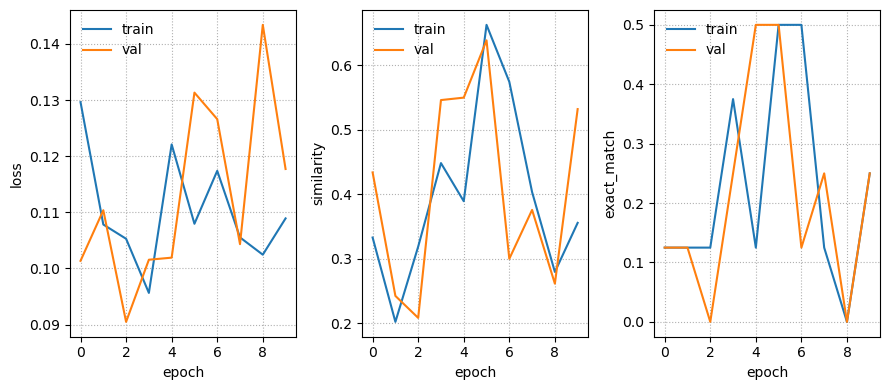

In [50]:
import matplotlib.pyplot as plt

def training_plot(metrics):
    fig, ax = plt.subplots(1, 3, figsize=(9,4))

    ax[0].set_ylabel('loss')
    ax[1].set_ylabel('similarity')
    ax[2].set_ylabel('exact_match')

    metrics = metrics.reset_index().groupby(['phase', 'epoch']).mean()
    train_metrics = metrics.loc['train']
    val_metrics = metrics.loc['val']

    for phase in ['train', 'val']:
        m = metrics.loc[phase]
        ax[0].plot(m.index, m.loss, label=phase)
        ax[1].plot(m.index, m.similarity, label=phase)
        ax[2].plot(m.index, m.exact_match, label=phase)
    
    for ax_i in ax:
        ax_i.set_axisbelow(True)
        ax_i.grid(linestyle=':')
        ax_i.set_xlabel('epoch')
        ax_i.legend(frameon=False)

    fig.tight_layout()
    return fig

training_plot(metrics_df).savefig(f'{out_name}_training.png', bbox_inches='tight')